In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
#torch.set_num_threads(1)

### 1 Learning to predict the Lorenz system using RNNs

#### Task 1

If the activation function is linear, the RNN becomes a linear system and cannot capture the nonlinear chaotic dynamics of the Lorenz-63 system. Therefore, it is essential to use a nonlinear activation function, such as tanh or ReLU, to model the complex behavior of the Lorenz attractor.

#### Task 2

In [2]:
class CustomDataset(Dataset):
    """Sample random subsequences of length T_seq from the provided dataset.
    The dataset is a torch tensor of shape (T, N)."""
    def __init__(self, data, T_seq):
        # T x N
        self.data = data
        self.T_seq = T_seq

    def __getitem__(self, t):
        # t is the index of the first time step
        # return a sequence of length T_seq
        # and the sequence shifted by one time step
        return self.data[t:t+self.T_seq, :], self.data[t+1:t+self.T_seq+1, :]	

    def __len__(self):
        # sets the allowed range of t
        return len(self.data) - self.T_seq - 1


class BatchSampler():
    """Samples sequences from the dataset and stacks them into batches."""
    def __init__(self, dataset, batch_size):
        self.B = batch_size
        self.dataset = dataset

    def __call__(self):
        # get indices
        batch = [self.dataset[i] for i in self.get_random_inital_conditions()]

        # stack the sequences into separate batches
        xs = torch.stack([x for x, _ in batch])
        ys = torch.stack([y for _, y in batch])

        # reshape to (T, B, N)
        return xs.permute(1, 0, 2), ys.permute(1, 0, 2)
        
    def get_random_inital_conditions(self):
        # return a list of initial conditions of size self.B
        return torch.randperm(len(self.dataset))[:self.B]

In [3]:
def train_RNN(
    rnn,
    output_layer,
    dataloader, 
    n_epochs, 
    print_every,
    lr=5e-4
):  
    # gather parameters
    rnn_params = list(rnn.parameters())
    output_layer_params = list(output_layer.parameters())

    # the optimizer performing stochastic gradient descent
    optimizer = torch.optim.Adam(rnn_params + output_layer_params, lr=lr)

    # the loss function
    criterion = nn.MSELoss()

    losses = []
    for epoch in range(n_epochs + 1):
        # get the data
        xs, ys = dataloader()

        # zero the gradients
        optimizer.zero_grad()

        # forward pass of the entire batch
        # implicitly initializes the hidden state
        # to zero!
        out, h = rnn(xs)
        y_pred = output_layer(out)

        # compute the loss
        loss = criterion(y_pred, ys)

        # backward pass, computes gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # store the loss
        losses.append(loss.item())

        # print the loss
        if epoch % print_every == 0:
            print('Epoch: {}, Loss: {:.5f}'.format(epoch, loss.item()))

    return losses

/var/folders/hg/w9_h01j97r39rl6psfg1h3_40000gn/T/ipykernel_12995/1448618812.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load('lorenz_data.pt')


torch.Size([100000, 3])
torch.Size([200, 32, 3]) torch.Size([200, 32, 3])
Training with 10 hidden units...
Epoch: 0, Loss: 1.07652
Epoch: 500, Loss: 0.06655
Epoch: 1000, Loss: 0.02587
Epoch: 1500, Loss: 0.00978
Epoch: 2000, Loss: 0.00512
Epoch: 2500, Loss: 0.00293
Epoch: 3000, Loss: 0.00243
Epoch: 3500, Loss: 0.00175
Epoch: 4000, Loss: 0.00129
Epoch: 4500, Loss: 0.00110
Epoch: 5000, Loss: 0.00070
Training with 20 hidden units...
Epoch: 0, Loss: 1.06237
Epoch: 500, Loss: 0.02002
Epoch: 1000, Loss: 0.00547
Epoch: 1500, Loss: 0.00355
Epoch: 2000, Loss: 0.00194
Epoch: 2500, Loss: 0.00143
Epoch: 3000, Loss: 0.00096
Epoch: 3500, Loss: 0.00055
Epoch: 4000, Loss: 0.00051
Epoch: 4500, Loss: 0.00030
Epoch: 5000, Loss: 0.00022
Training with 50 hidden units...
Epoch: 0, Loss: 1.17294
Epoch: 500, Loss: 0.00459
Epoch: 1000, Loss: 0.00228
Epoch: 1500, Loss: 0.00190
Epoch: 2000, Loss: 0.00105
Epoch: 2500, Loss: 0.00051
Epoch: 3000, Loss: 0.00030
Epoch: 3500, Loss: 0.00017
Epoch: 4000, Loss: 0.00015
Ep

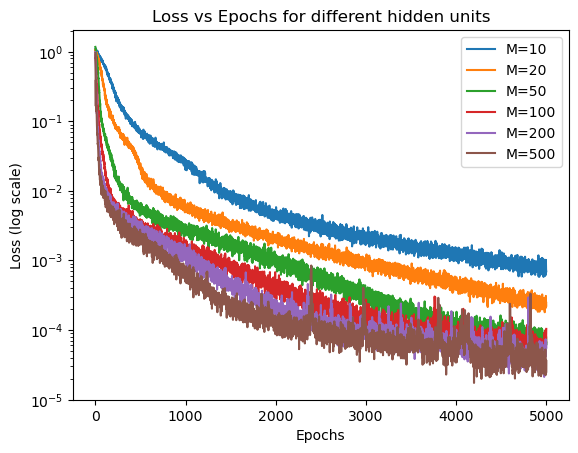

In [4]:
# set the parameters
hidden_units_list = [10, 20, 50, 100, 200, 500]
T_seq = 200
B = 32
epochs = 5000
learning_rate = 5e-4 # you can play around with this setting

# load the data
X = torch.load('lorenz_data.pt')
print(X.size())

# initialize the dataset
dataset = CustomDataset(X, T_seq)

# initialize the dataloader
dataloader = BatchSampler(dataset, B)
xs, ys = dataloader()
print(xs.size(), ys.size())

for M in hidden_units_list:
    print(f"Training with {M} hidden units...")
    # initialize RNN and output layer
    rnn = nn.RNN(input_size=X.size(1), hidden_size=M, nonlinearity='tanh')  # change to 'relu' for ReLU
    output_layer = nn.Linear(M, X.size(1))
    
    # train the model
    losses = train_RNN(rnn, output_layer, dataloader, n_epochs=epochs, print_every=int(epochs/10), lr=learning_rate)

    # plot the losses (log scale)
    plt.plot(losses, label=f'M={M}')

plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.legend()
plt.title('Loss vs Epochs for different hidden units')
plt.show()

The results show that as the number of hidden units $M$ increases, the model achieves faster loss reduction and lower final loss, indicating that more hidden units better capture the complex dynamics of the Lorenz system. However, larger $M$ values (e.g., 200 and 500) come with higher computational costs and greater loss fluctuations. Overall, $M=100$ offers the best balance between performance, stability, and efficiency, making it a more reasonable choice.

#### Task 3

In [6]:
# Use the best model
M = 100
rnn = nn.RNN(input_size=X.size(1), hidden_size=M, nonlinearity='tanh')
output_layer = nn.Linear(M, X.size(1))

# Train the model
losses = train_RNN(rnn, output_layer, dataloader, n_epochs=epochs, print_every=int(epochs/10), lr=learning_rate)

Epoch: 0, Loss: 1.00687
Epoch: 500, Loss: 0.00365
Epoch: 1000, Loss: 0.00235
Epoch: 1500, Loss: 0.00118
Epoch: 2000, Loss: 0.00049
Epoch: 2500, Loss: 0.00037
Epoch: 3000, Loss: 0.00014
Epoch: 3500, Loss: 0.00011
Epoch: 4000, Loss: 0.00008
Epoch: 4500, Loss: 0.00006
Epoch: 5000, Loss: 0.00004


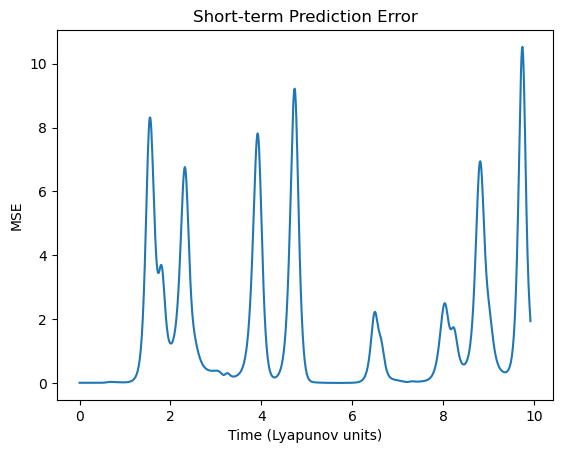

In [7]:
# Test data window, length T=1000
test_window = X[:1000]
T = test_window.size(0)

# Warm-up
warmup_steps = 100
hidden_state = None
for t in range(warmup_steps):
    _, hidden_state = rnn(test_window[t:t+1].unsqueeze(1), hidden_state)

# Prediction
predictions = []
input_step = test_window[warmup_steps: warmup_steps+1].unsqueeze(1)
for t in range(warmup_steps, T):
    out, hidden_state = rnn(input_step, hidden_state)
    prediction = output_layer(out.squeeze(0))
    predictions.append(prediction)
    input_step = prediction.unsqueeze(1)

# Compute MSE
ground_truth = test_window[warmup_steps:]
predictions = torch.stack(predictions).squeeze(1)
mse = ((predictions - ground_truth) ** 2).mean(dim=1)

# Plot the MSE
time_steps = torch.arange(len(mse)) * 0.01 / 0.906  # Lyapunov time
plt.plot(time_steps, mse.detach().numpy())
plt.xlabel('Time (Lyapunov units)')
plt.ylabel('MSE')
plt.title('Short-term Prediction Error')
plt.show()

The results indicate that the RNN model with $M=100$ hidden units is able to predict the Lorenz system dynamics accurately for short-term intervals, less than $1$ Lyapunov times. During this interval, the MSE remains relatively low, showing the model's ability to capture the system's local dynamics effectively. 

As time progresses beyond $1$ Lyapunov times, the MSE grows significantly due to the chaotic nature of the Lorenz system. This is an expected result since even small errors in the initial predictions are exponentially magnified over time in chaotic systems. The periodic fluctuations in the MSE after this point suggest that the model-generated trajectory retains some resemblance to the system's dynamics, though it diverges from the ground truth.

In conclusion, the RNN successfully captures the short-term behavior of the Lorenz system but struggles with long-term predictions due to the inherent unpredictability of chaotic systems. This result is consistent with theoretical expectations and demonstrates the model's effectiveness within the limits of short-term forecasting.

#### Task 4

In [8]:
# Generate a long trajectory from the RNN
T_long = 100000
trajectory = []
hidden_state = None
input_step = torch.randn(1, X.size(1)).unsqueeze(1)  # Initial condition

for _ in range(T_long):
    out, hidden_state = rnn(input_step, hidden_state)
    prediction = output_layer(out.squeeze(0))
    trajectory.append(prediction[0])
    input_step = prediction.unsqueeze(1)
trajectory = torch.stack(trajectory).detach().numpy()


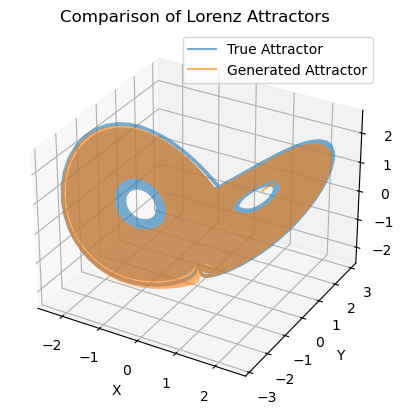

In [9]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# True attractor
ax.plot(X[:, 0], X[:, 1], X[:, 2], label='True Attractor', alpha=0.6)

# Generated attractor
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='Generated Attractor', alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.legend()
plt.title('Comparison of Lorenz Attractors')
plt.show()

The model-generated attractor closely resembles the true Lorenz attractor in shape and structure, demonstrating that the RNN effectively captures the long-term dynamics of the system. While there are minor local deviations due to the chaotic nature of the Lorenz system, the overall trajectory remains stable and confined within the attractor region, showing that the model does not diverge or collapse into a fixed point. This indicates that the RNN is successful in reproducing the global behavior of the Lorenz system over an extended period, aligning well with the expected dynamics.